In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1


In [3]:
vector.register_awkward() 

In [4]:
DATATYPE = "data"
assert((DATATYPE == "mc") or (DATATYPE == "data"))
BASEDIR = "/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC = True if DATATYPE == "mc" else False

In [5]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [6]:
SAMPLE_RUNS = [290222,290223,290254,290293,290297,290300,290323,290324,290327,290350,290374,290375,290401,290404,290411,290423,290425]

In [7]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
events = file["eventsTree"]
events.show()
events.num_entries

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'data'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | 

1232789

In [8]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_GenE"]},
                    with_name='Momentum4D')

def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hEta:hist.Hist, hPt:hist.Hist, hMass:hist.Hist,
              eventSelector = lambda x:[True]*len(x),
              trackSelector = lambda x:[True]*len(x), 
              verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report = True):
        events = batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(events)
        goodTracks=tracks[trackSelector(tracks)]
    
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi))
        hEta.fill(ak.flatten(goodTracks.eta))
        hPt.fill(ak.flatten(goodTracks.pt))
        hMass.fill(ak.flatten(goodTracks.mass))

        if verbose:
            print(batch[1])
        gc.collect()

In [9]:
%%time
## SINGLE MUON TRACK PLOTS
#No cuts
hMagRaw = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiRaw = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
#Event selection
hMagEvSel = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiEvSel = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))

hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hPt = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMass = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))

scan(dataDescription = f"{BASEDIR}/run{SAMPLE_RUNS[0]}.{DATATYPE}.root:eventsTree",
          hMag = hMagEvSel, hPhi = hPhiEvSel, hEta = hEta, hPt = hPt, hMass = hMass)
"""eventSelector=lambda x: x["isCMSL"]==True,
trackSelector=lambda x: (x.p>5) & (x.eta>-4)"""


CPU times: user 4.23 s, sys: 0 ns, total: 4.23 s
Wall time: 4.44 s


'eventSelector=lambda x: x["isCMSL"]==True,\ntrackSelector=lambda x: (x.p>5) & (x.eta>-4)'

In [10]:
def mag(px:float, py:float, pz:float):
    """Returns an array of the norms of the 3-vectors (px,py,pz)."""
    return np.sqrt(px*px + py*py + pz*pz)

def costheta(px:float, py:float, pz:float):
    """Returns an array of cos(theta) for the 3 vectors (px,py,pz)."""
    ptot = mag(px, py, pz);
    return np.divide(pz, ptot)

def eta(px:float, py:float, pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px, py, pz)
    return -0.5* np.log( (1.0-ct)/(1.0+ct) )

def pT(px:float, py:float):
    """Returns the transverse momentum of the 2 vector (px, py)."""
    return np.sqrt(px*px + py*py)

def m0(E:float, px:float, py:float, pz:float):
    """Returns the invariant mass of the 4-Momentum."""
    ptot = mag(px, py, pz)
    return np.sqrt(abs(E*E - ptot*ptot))

def rapidity(E:float, pz:float):
    """Returns the rapidity of the track."""
    return 0.5 * np.log((E+pz)/(E-pz))

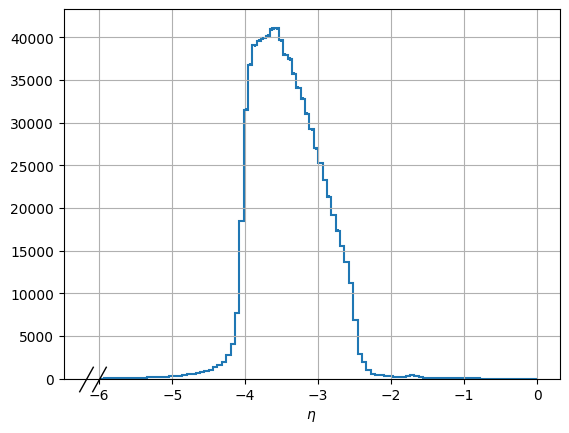

In [11]:
hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))

for m in events.iterate(["nMuons", "Muon_Px", "Muon_Py", "Muon_Pz"], step_size=10000):
    _ = m[m.nMuons>0]
    etas = eta(_["Muon_Px"], _["Muon_Py"], _["Muon_Pz"])
    hEta.fill(ak.flatten(etas))
    
hEta.plot();
plt.grid(True)

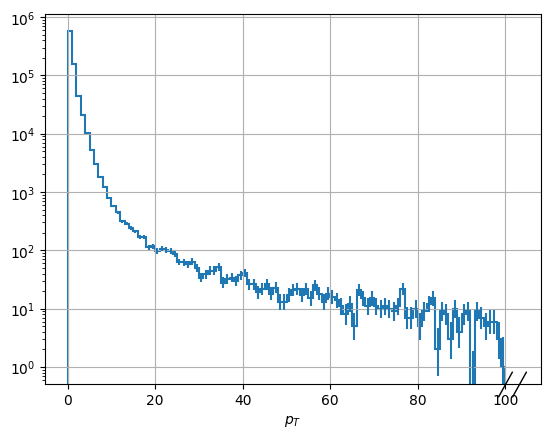

In [12]:
hpT = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))

for m in events.iterate(["nMuons", "Muon_Px", "Muon_Py"], step_size = 10000):
    _ = m[m.nMuons > 0]
    pTs = pT(_["Muon_Px"], _["Muon_Py"])
    hpT.fill(ak.flatten(pTs))
    
hpT.plot()
plt.yscale('log')
plt.grid(True)

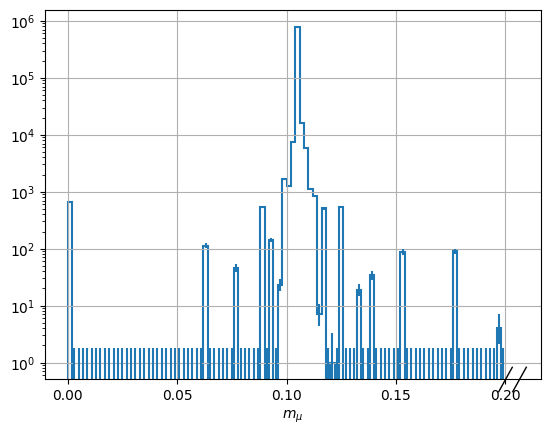

In [13]:
hm0 = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))

for m in events.iterate(["nMuons", "Muon_E", "Muon_Px", "Muon_Py", "Muon_Pz"], step_size = 10000):
    _ = m[m.nMuons > 0]
    m0s = m0(_["Muon_E"], _["Muon_Px"], _["Muon_Py"], _["Muon_Pz"])
    hm0.fill(ak.flatten(m0s))

hm0.plot()
plt.yscale('log')
plt.grid(True)

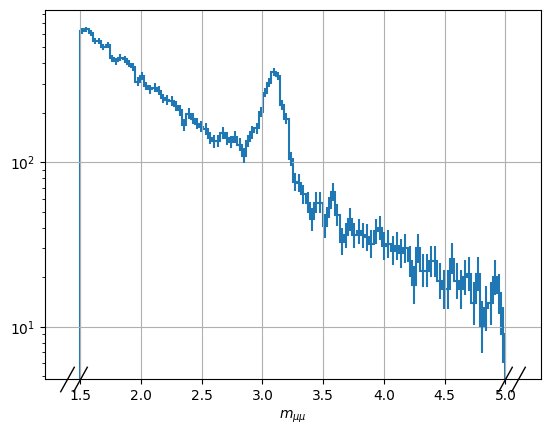

In [14]:
hm0_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hm0_LS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

for m in events.iterate(["nMuons", "Muon_E", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_Charge"], step_size = 10000):
    
    _ = m[m.nMuons == 2]
    
    for t in _:
        
        E = t["Muon_E"][0] + t["Muon_E"][1]
        Px = t["Muon_Px"][0] + t["Muon_Px"][1]
        Py = t["Muon_Py"][0] + t["Muon_Py"][1]
        Pz = t["Muon_Pz"][0] + t["Muon_Pz"][1]
        m0s = m0(E, Px, Py, Pz)
        
        if t["Muon_Charge"][0] != t["Muon_Charge"][1]:
            hm0_OS.fill(m0s)
            
        if t["Muon_Charge"][0] == t["Muon_Charge"][1]:
            hm0_LS.fill(m0s)
            
hm0_OS.plot()
plt.yscale('log')
plt.grid(True)

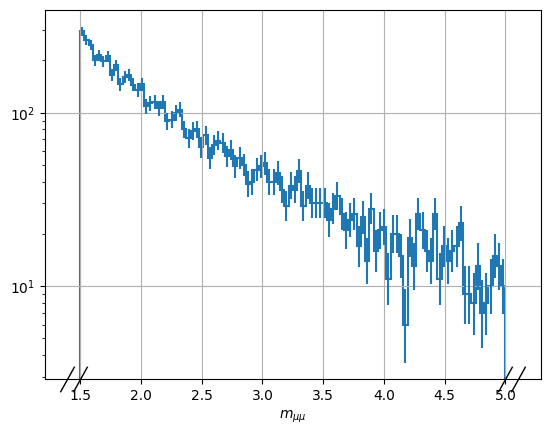

In [15]:
hm0_LS.plot()
plt.yscale('log')
plt.grid(True)